In [1]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
                                                               features=select_features, covariates=False)
# features = getFeatures()

In [3]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 7])
torch.Size([64, 10])


In [22]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        # take out time invariant features
        idx = select_features.index('payload')
        # filter out the payload feature
        x = torch.cat((x[:, :, :idx], x[:, :, idx+1:]), dim=2) # (batch_size, seq_len, input_size-1)
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c, idx


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_fixed_inputs, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + num_fixed_inputs, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell, fixed_inputs):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = torch.cat((output, fixed_inputs), dim=2)
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, num_fixed_inputs,
                 tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_fixed_inputs, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c, fixed_idx = self.encoder(x)
        # TODO: assert number of fixed_idx = num_fixed_inputs
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        xt = torch.cat((xt[:, :, :fixed_idx], xt[:, :, fixed_idx+1:]), dim=2)
        fixed_inputs = x[:, 0, fixed_idx].unsqueeze(1).unsqueeze(2) # (batch_size, 1)
        outputs = self.decoder(xt, h, c, fixed_inputs) # (batch_size, output_len, 1)
        return outputs

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_fixed_inputs = 1
input_size = len(select_features) - num_fixed_inputs
input_len = 24
output_len = 10
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [64,64,64,64], hidden_size, num_fixed_inputs, num_layers=num_layers).to(device)

cuda


In [13]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 27
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select_best_model_{input_len}-{output_len}.pt')


Epoch 1/27 [TRAIN]: 100%|██████████| 2284/2284 [00:37<00:00, 60.52it/s, train_loss=0.00408]


Epoch 1/27, Average Training Loss: 0.005546


Epoch 1/27 [VAL]: 100%|██████████| 783/783 [00:04<00:00, 160.38it/s, val_loss=0.00689]


Epoch 1/27, Average Validation Loss: 0.003378


Epoch 2/27 [TRAIN]: 100%|██████████| 2284/2284 [00:41<00:00, 55.63it/s, train_loss=0.00367]


Epoch 2/27, Average Training Loss: 0.003647


Epoch 2/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 145.70it/s, val_loss=0.00713]


Epoch 2/27, Average Validation Loss: 0.003061


Epoch 3/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.54it/s, train_loss=0.00198]


Epoch 3/27, Average Training Loss: 0.003364


Epoch 3/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 133.86it/s, val_loss=0.00507]


Epoch 3/27, Average Validation Loss: 0.003272


Epoch 4/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.47it/s, train_loss=0.00302]


Epoch 4/27, Average Training Loss: 0.003224


Epoch 4/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 137.27it/s, val_loss=0.00449]


Epoch 4/27, Average Validation Loss: 0.002801


Epoch 5/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 54.21it/s, train_loss=0.0034] 


Epoch 5/27, Average Training Loss: 0.003128


Epoch 5/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 142.33it/s, val_loss=0.00456]


Epoch 5/27, Average Validation Loss: 0.002785


Epoch 6/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.26it/s, train_loss=0.00226]


Epoch 6/27, Average Training Loss: 0.003046


Epoch 6/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 141.38it/s, val_loss=0.00559]


Epoch 6/27, Average Validation Loss: 0.002749


Epoch 7/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.88it/s, train_loss=0.00215]


Epoch 7/27, Average Training Loss: 0.002974


Epoch 7/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 135.80it/s, val_loss=0.00432]


Epoch 7/27, Average Validation Loss: 0.002774


Epoch 8/27 [TRAIN]: 100%|██████████| 2284/2284 [00:41<00:00, 54.69it/s, train_loss=0.0023] 


Epoch 8/27, Average Training Loss: 0.002924


Epoch 8/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 142.74it/s, val_loss=0.00474]


Epoch 8/27, Average Validation Loss: 0.002767


Epoch 9/27 [TRAIN]: 100%|██████████| 2284/2284 [00:41<00:00, 55.06it/s, train_loss=0.00243]


Epoch 9/27, Average Training Loss: 0.002876


Epoch 9/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 142.34it/s, val_loss=0.00445]


Epoch 9/27, Average Validation Loss: 0.002636


Epoch 10/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.22it/s, train_loss=0.00291]


Epoch 10/27, Average Training Loss: 0.002838


Epoch 10/27 [VAL]: 100%|██████████| 783/783 [00:06<00:00, 126.99it/s, val_loss=0.00554]


Epoch 10/27, Average Validation Loss: 0.002625


Epoch 11/27 [TRAIN]: 100%|██████████| 2284/2284 [00:45<00:00, 49.89it/s, train_loss=0.00357]


Epoch 11/27, Average Training Loss: 0.002806


Epoch 11/27 [VAL]: 100%|██████████| 783/783 [00:06<00:00, 126.93it/s, val_loss=0.00435]


Epoch 11/27, Average Validation Loss: 0.002638


Epoch 12/27 [TRAIN]: 100%|██████████| 2284/2284 [00:45<00:00, 49.69it/s, train_loss=0.00191]


Epoch 12/27, Average Training Loss: 0.002778


Epoch 12/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 133.24it/s, val_loss=0.0048] 


Epoch 12/27, Average Validation Loss: 0.002614


Epoch 13/27 [TRAIN]: 100%|██████████| 2284/2284 [00:45<00:00, 50.27it/s, train_loss=0.00299]


Epoch 13/27, Average Training Loss: 0.002745


Epoch 13/27 [VAL]: 100%|██████████| 783/783 [00:06<00:00, 123.27it/s, val_loss=0.00404]


Epoch 13/27, Average Validation Loss: 0.002547


Epoch 14/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.68it/s, train_loss=0.00155]


Epoch 14/27, Average Training Loss: 0.002723


Epoch 14/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 133.76it/s, val_loss=0.00412]


Epoch 14/27, Average Validation Loss: 0.002557


Epoch 15/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.51it/s, train_loss=0.00197]


Epoch 15/27, Average Training Loss: 0.002724


Epoch 15/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 143.09it/s, val_loss=0.00437]


Epoch 15/27, Average Validation Loss: 0.002566


Epoch 16/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.00it/s, train_loss=0.00316]


Epoch 16/27, Average Training Loss: 0.002684


Epoch 16/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 134.33it/s, val_loss=0.00418]


Epoch 16/27, Average Validation Loss: 0.002549


Epoch 17/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.41it/s, train_loss=0.00209]


Epoch 17/27, Average Training Loss: 0.002678


Epoch 17/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 143.90it/s, val_loss=0.00429]


Epoch 17/27, Average Validation Loss: 0.002494


Epoch 18/27 [TRAIN]: 100%|██████████| 2284/2284 [00:40<00:00, 56.23it/s, train_loss=0.00196]


Epoch 18/27, Average Training Loss: 0.002648


Epoch 18/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 140.67it/s, val_loss=0.00411]


Epoch 18/27, Average Validation Loss: 0.002613


Epoch 19/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 54.10it/s, train_loss=0.00169]


Epoch 19/27, Average Training Loss: 0.002638


Epoch 19/27 [VAL]: 100%|██████████| 783/783 [00:06<00:00, 129.80it/s, val_loss=0.00416]


Epoch 19/27, Average Validation Loss: 0.002523


Epoch 20/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.36it/s, train_loss=0.00235]


Epoch 20/27, Average Training Loss: 0.002622


Epoch 20/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 137.70it/s, val_loss=0.0043] 


Epoch 20/27, Average Validation Loss: 0.002550


Epoch 21/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.53it/s, train_loss=0.00237] 


Epoch 21/27, Average Training Loss: 0.002606


Epoch 21/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 144.24it/s, val_loss=0.00447]


Epoch 21/27, Average Validation Loss: 0.002747


Epoch 22/27 [TRAIN]: 100%|██████████| 2284/2284 [00:41<00:00, 55.09it/s, train_loss=0.0037] 


Epoch 22/27, Average Training Loss: 0.002600


Epoch 22/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 143.62it/s, val_loss=0.00397]


Epoch 22/27, Average Validation Loss: 0.002458


Epoch 23/27 [TRAIN]: 100%|██████████| 2284/2284 [00:41<00:00, 55.32it/s, train_loss=0.00231]


Epoch 23/27, Average Training Loss: 0.002583


Epoch 23/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 137.39it/s, val_loss=0.00397]


Epoch 23/27, Average Validation Loss: 0.002568


Epoch 24/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.82it/s, train_loss=0.00259] 


Epoch 24/27, Average Training Loss: 0.002569


Epoch 24/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 137.54it/s, val_loss=0.00423]


Epoch 24/27, Average Validation Loss: 0.002504


Epoch 25/27 [TRAIN]: 100%|██████████| 2284/2284 [00:42<00:00, 53.17it/s, train_loss=0.00225]


Epoch 25/27, Average Training Loss: 0.002565


Epoch 25/27 [VAL]: 100%|██████████| 783/783 [00:06<00:00, 129.58it/s, val_loss=0.00413]


Epoch 25/27, Average Validation Loss: 0.002442


Epoch 26/27 [TRAIN]: 100%|██████████| 2284/2284 [00:45<00:00, 50.16it/s, train_loss=0.00321]


Epoch 26/27, Average Training Loss: 0.002539


Epoch 26/27 [VAL]: 100%|██████████| 783/783 [00:06<00:00, 126.81it/s, val_loss=0.00413]


Epoch 26/27, Average Validation Loss: 0.002455


Epoch 27/27 [TRAIN]: 100%|██████████| 2284/2284 [00:43<00:00, 52.73it/s, train_loss=0.00283]


Epoch 27/27, Average Training Loss: 0.002529


Epoch 27/27 [VAL]: 100%|██████████| 783/783 [00:05<00:00, 135.92it/s, val_loss=0.00417]

Epoch 27/27, Average Validation Loss: 0.002462


Test loss: 0.0022191170137375593
MAPE: 37.145652770996094


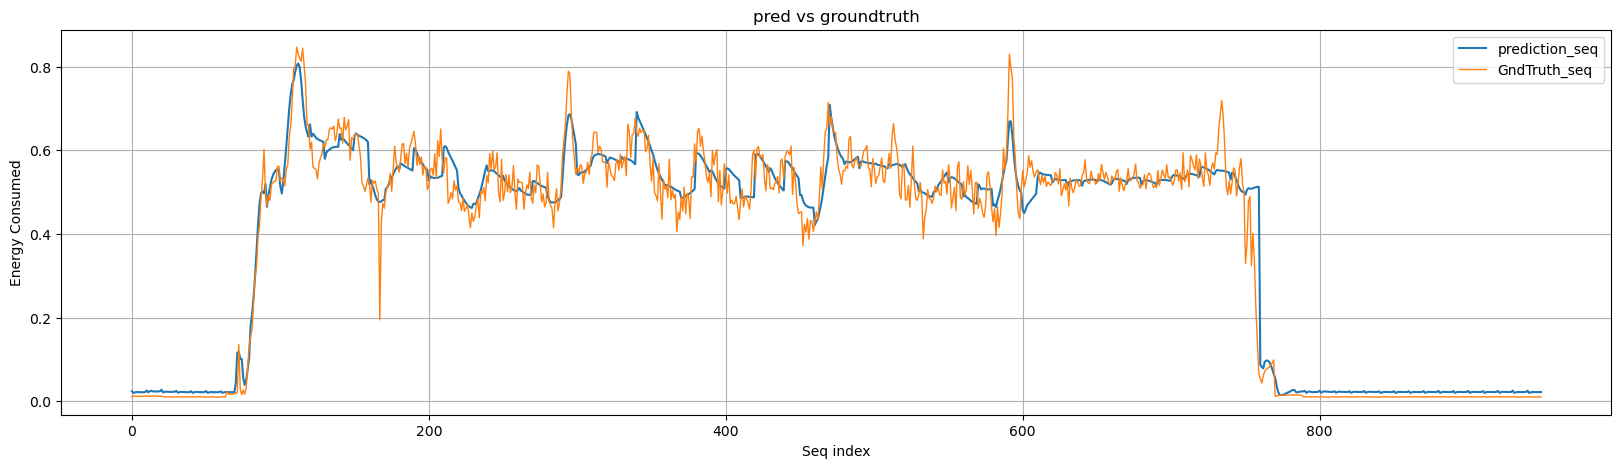

In [25]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load('TCN_LSTM_select_best_model_24-10.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,24,10)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [26]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load('TCN_LSTM_select_best_model_24-10.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
test_nums.remove(273)

for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,24,10)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    print(f"Flight {f_num}:")

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        error = nn.MSELoss()(outputs, targets)
        print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        print(f"MAPE: {mape}")

Flight 3:
Test loss: 0.0029777002055197954
MAPE: 20.976139068603516
Flight 124:
Test loss: 0.0030685586389154196
MAPE: 23.235849380493164
Flight 16:
Test loss: 0.002526950789615512
MAPE: 15.568193435668945
Flight 262:
Test loss: 0.0015653102891519666
MAPE: 12.082917213439941
Flight 221:
Test loss: 0.000739866984076798
MAPE: 4.631964206695557
Flight 94:
Test loss: 0.0017463592812418938
MAPE: 30.918466567993164
Flight 255:
Test loss: 0.0023565231822431087
MAPE: 50.98945617675781
Flight 263:
Test loss: 0.0007374652777798474
MAPE: 10.856463432312012
Flight 135:
Test loss: 0.0024245651438832283
MAPE: 14.360305786132812
Flight 17:
Test loss: 0.00281249126419425
MAPE: 11.953807830810547
Flight 233:
Test loss: 0.00119493727106601
MAPE: 11.382669448852539
Flight 20:
Test loss: 0.002853426383808255
MAPE: 9.975415229797363
Flight 228:
Test loss: 0.003140621120110154
MAPE: 43.71738815307617
Flight 113:
Test loss: 0.0036895377561450005
MAPE: 25.253582000732422
Flight 193:
Test loss: 0.0015225546667

In [27]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 35.6116784779483


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""